# Introduction

This notebook is the final version of the Computer Based Physical Modeling project to be submitted on September 4th 2024. Supplementary material and proof of exploration can be provided upon request. It mostly relies on the libraries qutip, numpy, and matplotlyb.pyplot. Most importatntly qutip is used to describe quantum states and operators, and compute their evolution.

The goal of this notebook is to explore NV centers in diamond and their spin properties. The first part of the notebook studies eigenvalues and eigenfrequencies of the time independent Hamiltonian of the NV center in diamond in presence of a constant applied magnetic field, defined as 

$\hat{H}_0 = 2\pi \left(D\cdot \hat{S}_z^2 + \gamma_e \left[B_\parallel \hat{S_z} + B_\perp \hat{S_y}\right]\right)$

Where the $\hat{z}$ axis is the orientation of the NV center in the diamond crystal lattice, $\vec{B}$ is decomposed into a parallel and a perpendicular component to this axis, and $D=2.87$ GHz and $\gamma_e=28.03$ GHz/T are constants corresponding to zero field splitting, and gyromagnetic ratio of the electron respectively. The $2\pi$ prefactor is necessary to have the Hamiltonian in units of energy, as $\hbar$ is implicitly defined to be 1.

Spin operators are the Pauli X, Y, and Z operators, which are 3 by 3 matrices, just like the Hamiltonian.

It will later be useful to define a function to compute an Hamiltonian given a NV orientation in cartesian coordinates, and a vector describing magnetic field in tesla, also in cartesian coordinates. In this first cell define such functions, print spin operators, and a sample Hamiltonian with static magnetic field of $10$ mT parallel to the NV axis.

In [10]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

D = 2.87  # Zero-field splitting in GHz
g_e = 28.03  # Gyromagnetic ratio of the electron, units are GHz/T
_2PI = 2 * np.pi

# Spin operators
Sz = qt.jmat(1, 'z')
Sx = qt.jmat(1, 'x')
Sy = qt.jmat(1, 'y')

# Given cartesian NV orientaion and applied magnetic field, separate the magnetic field into parallel and perpendicular components, return as a tuple
def decompose_vector(orientation, B_field):
    # Normalize the orientation vector
    orientation = np.array(orientation)
    B_field = np.array(B_field)
    
    orientation_norm = np.linalg.norm(orientation)
    
    if orientation_norm == 0:
        raise ValueError("Orientation vector must be non-zero.")
    
    # Unit vector along orientation
    unit_orientation = orientation / orientation_norm
    
    # Projection of B_field onto orientation (parallel component)
    B_parallel_magnitude = np.dot(B_field, unit_orientation)
    B_parallel = B_parallel_magnitude * unit_orientation
    
    # Perpendicular component of B_field
    B_perpendicular = B_field - B_parallel
    
    return np.linalg.norm(B_parallel), np.linalg.norm(B_perpendicular)

# compute the Hamiltonian as experienced by an NV center with a given orientation in a given magnetic field
def effective_hamiltonian(orientation, B_field):
    B_parallel, B_perpendicular = decompose_vector(orientation, B_field)
    
    # Hamiltonian H = 2*pi*(D * (Sz^2) + g_e * (B_parallel * Sz))
    return _2PI * ( D * Sz**2 + g_e * (B_parallel * Sz + B_perpendicular * Sy))

example_hamiltonian = effective_hamiltonian((0,0,1), (0, 0, 0.01))

print(f'Here are the spin operator as created by qutip: \n\n Sx: \n{Sx}\n\n Sy: \n{Sy}\n\n Sz: \n{Sz} \n\n')
print(f'Time independent Hamiltonian defined for 10mT parallel to the z axis: \n\n{example_hamiltonian}')


Here are the spin operator as created by qutip: 

 Sx: 
Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.70710678]
 [0.         0.70710678 0.        ]]

 Sy: 
Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j         0.-0.70710678j 0.+0.j        ]
 [0.+0.70710678j 0.+0.j         0.-0.70710678j]
 [0.+0.j         0.+0.70710678j 0.+0.j        ]]

 Sz: 
Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]] 


Time independent Hamiltonian defined for 10mT parallel to the z axis: 

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=CSR, isherm=True
Qobj data =
[[19.79391867  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         16.27156499]]


# Eigenvalues of Hamiltonian

qutip provides a straightforward way to diagonalize a matrix and return its eigenvalues and eigenvectors. Let's print them for the same example applied magnetic field.

In [11]:
print(f'Eigenstates: \n\n {example_hamiltonian.eigenstates()} \n Eigenvalues: \n\n {example_hamiltonian.eigenenergies()}')

Eigenstates: 

 (array([ 0.        , 16.27156499, 19.79391867]), array([Quantum object: dims=[[3], [1]], shape=(3, 1), type='ket', dtype=Dense
       Qobj data =
       [[0.]
        [1.]
        [0.]]                                                                ,
       Quantum object: dims=[[3], [1]], shape=(3, 1), type='ket', dtype=Dense
       Qobj data =
       [[0.]
        [0.]
        [1.]]                                                                ,
       Quantum object: dims=[[3], [1]], shape=(3, 1), type='ket', dtype=Dense
       Qobj data =
       [[1.]
        [0.]
        [0.]]                                                                ],
      dtype=object)) 
 Eigenvalues: 

 [ 0.         16.27156499 19.79391867]


Each eigenstate corresponds to a spin-state, namely $m_S=0$ yields eigenvalue 0, while $m_S=-1$ and $m_S=+1$ have larger eigenvalues. The order of eigenvalues changes for larger values of $B$, but this is outside the scope of this notebook.

Define these three states as variables, and define their associated density matrices. Print density matrix of $\ket{-1}$, defined as $\ket{-1}\bra{-1}=\rho_-$.

In [12]:
state_zero = qt.basis(3, 1)
rho_zero = state_zero * state_zero.dag()
state_plus = qt.basis(3, 0)
rho_plus = state_plus * state_plus.dag()
state_minus = qt.basis(3, 2)
rho_minus = state_minus * state_minus.dag()

rho_minus

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]

# Pulsing the NV

Apply now a pulse resembling a microwave source of given frequency. This is done by applying to the system the $\hat{S}_x$ operator multiplied by a sinusoidal prefactor of the form

$amp\cdot \sin\left(\omega t\right)$

Observe the evolution of the expectation values of the density matrices of the three states as a function of time by applying a pulse with given frequency.

This is done by taking advantage of the mesolve method from qutip. This method takes as argument a time independent or dependent Hamiltonian and a state for which to compute the evolution, as well as a list of times at which to compute the intermediate states. This numerically solves the Schrödinger equation for each point in time. Define then a time vector of $100$ points going from $t=0$ ns to $t=50$ ns, and plot the evolution of the density matrices associated to the initial states as a function of time. For this purpose define a function called evolve_and_plot().

$i\hbar \frac{d}{dt}\ket{\psi} = \hat{H}\ket{\psi}$

Expectation values are extracted from intermediate states by using the qtip.expect() method, which returns the expectation value given an operator and the actual state of the system.

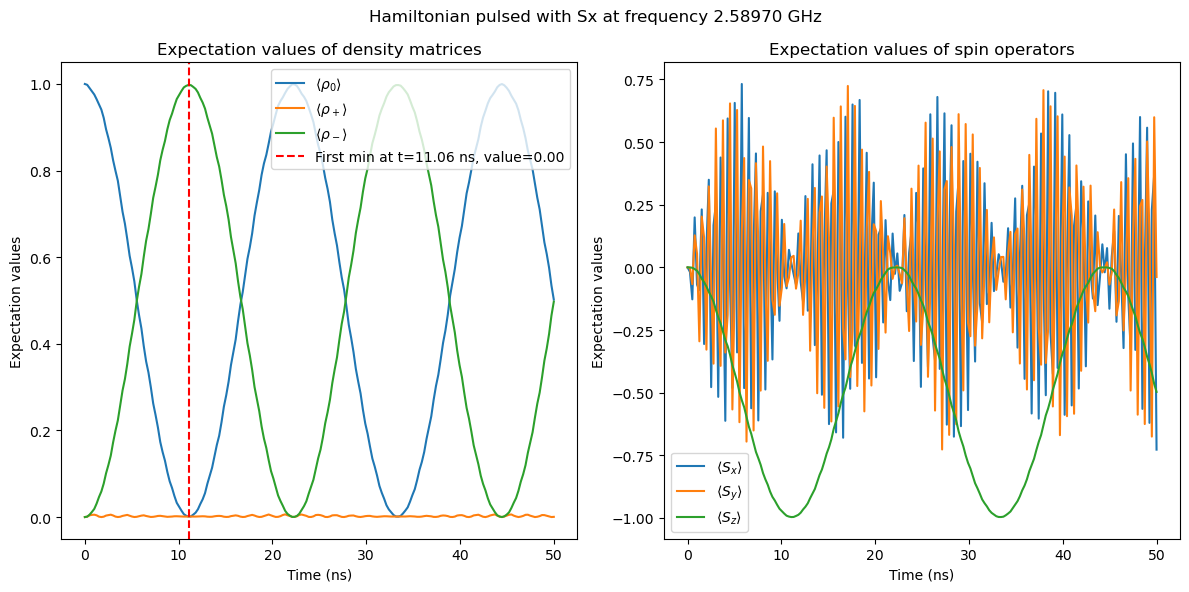

In [13]:
def pulse(t, args):
    return args['amp'] * np.sin(args['w'] * t)

def evolve_and_plot(H0, initial_state, times, pulse_arguments):
    # Solve the Schrodinger equation
    result = qt.mesolve([H0, [Sx, pulse]], initial_state, times, args=pulse_arguments)

    # Calculate the expectation values
    expect_rho_zero = qt.expect(rho_zero, result.states)
    expect_rho_plus = qt.expect(rho_plus, result.states)
    expect_rho_minus = qt.expect(rho_minus, result.states)

    expect_sigma_x = qt.expect(Sx, result.states)
    expect_sigma_y = qt.expect(Sy, result.states)
    expect_sigma_z = qt.expect(Sz, result.states)

    # Find the first minimum of expect_rho_zero
    first_min_index = np.argmin(expect_rho_zero[0:50])
    first_min_time = times[first_min_index]
    first_min_value = expect_rho_zero[first_min_index]

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.suptitle(f'Hamiltonian pulsed with Sx at frequency {pulse_arguments["w"] / _2PI:.5f} GHz')

    # Plot the expectation values of the density matrices
    plt.subplot(1, 2, 1)
    plt.plot(times, expect_rho_zero, label=r'$\langle \rho_0 \rangle$')
    plt.plot(times, expect_rho_plus, label=r'$\langle \rho_+ \rangle$')
    plt.plot(times, expect_rho_minus, label=r'$\langle \rho_- \rangle$')
    #plt.plot(times, pulse(times, args=pulse_arguments), label='Intensity of applied operator', color='grey')
    plt.xlabel('Time (ns)')
    plt.ylabel('Expectation values')
    plt.axvline(x=first_min_time, color='r', linestyle='--', label=f'First min at t={first_min_time:.2f} ns, value={first_min_value:.2f}')
    plt.title('Expectation values of density matrices')
    plt.legend(loc='upper right')

    # Plot the expectation values of the spin operators
    plt.subplot(1, 2, 2)
    plt.plot(times, expect_sigma_x, label=r'$\langle S_x \rangle$')
    plt.plot(times, expect_sigma_y, label=r'$\langle S_y \rangle$')
    plt.plot(times, expect_sigma_z, label=r'$\langle S_z \rangle$')
    #plt.plot(times, pulse(times, args=pulse_arguments), label='Intensity of applied operator', color='grey')
    plt.xlabel('Time (ns)')
    plt.ylabel('Expectation values')
    plt.title('Expectation values of spin operators')
    plt.legend()

    plt.tight_layout()


    plt.show()

resonant_freq = example_hamiltonian.eigenenergies()[1] - example_hamiltonian.eigenenergies()[0]

# Define pulse frequency as difference between spin states 0 and -1, amplitude arbitrarily defined as 0.4
pulse_arguments = {
    'w': resonant_freq, 
    'amp': 0.4
}

times = np.linspace(0, 50, 200) 

evolve_and_plot(example_hamiltonian, state_zero, times, pulse_arguments)

Pulsing at the frequency corresponding to the energy splitting between states $\ket{0}$ and $\ket{-1}$ yields a periodic inversion of the probabilities of finding the system in the corresponding states. This can be understood by thinking of a pulse of duration $\tau$ as implementing a rotation by angle $\theta$ of the state around the $x$ axis of the Bloch sphere, where the poles are the just mentioned states. This can be visualized using the Bloch sphere representation offered by qutip.

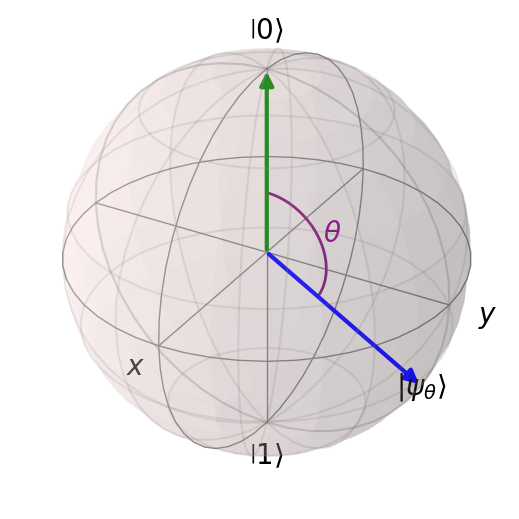

In [14]:
# Define the initial state north pole
initial_state_for_bloch = qt.basis(2, 0)

# Rotation angle (120 degrees in radians)
theta = np.deg2rad(120)

# Define the rotation operator around the x-axis
rotation_operator = qt.Qobj([[np.cos(theta), -1j * np.sin(theta)],
                             [-1j * np.sin(theta), np.cos(theta)]])

# Apply the rotation to the initial state
rotated_state = rotation_operator * initial_state_for_bloch

# Get the state vectors in 3D for the Bloch sphere
initial_state_vector = [0, 0, 1]
rotated_state_vector = [0, np.sin(theta), np.cos(theta)]  # Rotated state
thetalabel_location = [0, np.sin(theta / 2) / 2.4, np.cos(theta / 2) / 2.4]

initial_state_vector_scaled = [coord / 3 for coord in initial_state_vector]
rotated_state_vector_scaled = [coord / 3 for coord in rotated_state_vector]

bloch_sphere = qt.Bloch()

# Show initial state and rotated state
bloch_sphere.add_states(initial_state_for_bloch)
bloch_sphere.add_states(rotated_state)

bloch_sphere.vector_color = ['g', 'b']
bloch_sphere.add_annotation(rotated_state_vector, r"$|\psi_\theta\rangle$")
bloch_sphere.add_annotation(thetalabel_location, r"$\theta$", color='purple')

bloch_sphere.add_arc(initial_state_vector_scaled, rotated_state_vector_scaled, color='purple', lw=2)
bloch_sphere.show()


The pulse duration printed in the legend of the pulsing plot, corresponding to the first minimum of the expectation value of $\rho_0$ corresponds to a $\pi$ pulse, which rotates the state around the $x$ axis by $180$ degrees. This oscillatory behaviour is known as Rabi oscillations. Notice also that the value of the first minimum is zero, meaning that the probability of the system being in state $\ket{0}$ is 0.

## Off resonant pulsing

Now observe what happens if the system is pulsed at a frequency slightly lower or slightly higher than the resonant one. Arbitrarily now choose to use the other resonant frequency ($\ket{0} \leftrightarrow \ket{+1}$), and detune it by multiplying it first by $0.99$, then by $1.02$, again arbitrarily chosen values.



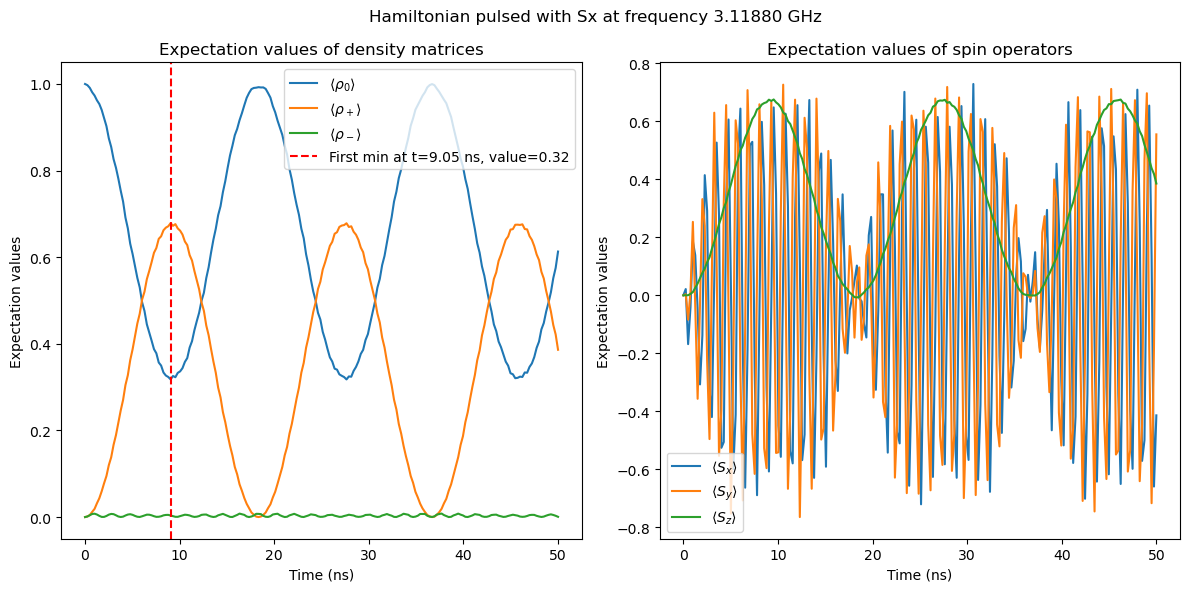

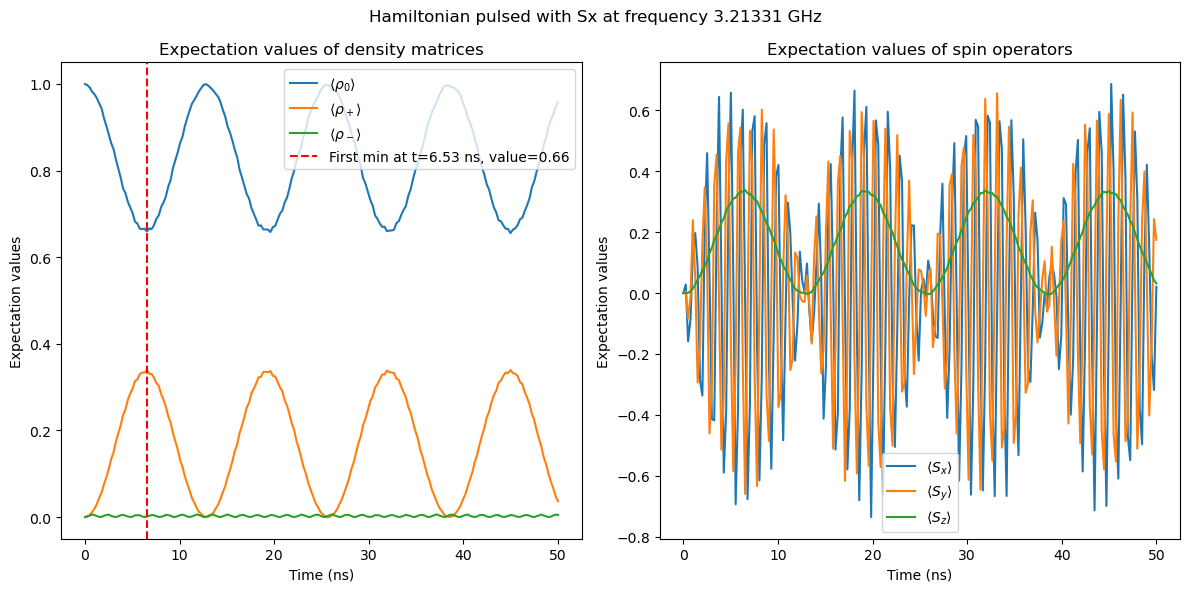

In [15]:
resonant_freq = example_hamiltonian.eigenenergies()[2] - example_hamiltonian.eigenenergies()[0]

pulse_arguments = {
    'w': resonant_freq * 0.99, 
    'amp': 0.4
}

evolve_and_plot(example_hamiltonian, state_zero, times, pulse_arguments)

pulse_arguments = {
    'w': resonant_freq * 1.02, 
    'amp': 0.4
}

evolve_and_plot(example_hamiltonian, state_zero, times, pulse_arguments)

Three main takeaway messages can be understood from the just created plots:

- Pulsing the NV with a frequency detuned from the resonant one yields lower 'amplitude' in the probability oscillations

- The minimum in such oscillations is reached earlier than for resonant frequency

- Pulsing near the resonant frequency for different transitions ends up 'exciting' that transition. In this case $\ket{0} \leftrightarrow \ket{+1}$

# Optically Detected Magnetic Resonance (ODMR)

Now observe what happens to the expectation value of $m_S=0$ as the system is pulsed with varied frequency, in a range centered around zero field splitting $D$. Pulse length is arbitrarily chosen to be $50$ ns.

This plot closely resembles a ODMR, Optically Detected Magnetic Resonance. In the case of NV centers in diamonds, an optical excitation of an NV with $m_s=\pm 1$ has a higher probability of relaxing to ground state in way that doesn't involve the emission of a photon in the range of the energy gap (because of Inter System Crossing) compared to NVs with $m_s=0$. This translates to the fluorescence manifesting a 'dip' in correlation to spins not being in the initial state.

The main reason why a lab-based ODMR spectrum has a much lower contrast compared to this simulation is that even for NVs with $m_s\neq 0$ the fluorescence is not zero. The resonant frequencies (dip positions) are however the same.

The ODMR spectrum is produced for a variety of values of $B$, to explore what happens with changing applied magnetic field. Magnetic field is kept parallel to $z$.

Define an ODMR function that returns the expectation values after such pulse for each applied frequency. This function makes use of caching in file form for time saving reasons.

B_z = 2.0 mT: Resonant values 2.8139 and 2.9261 GHz
B_z = 5.0 mT: Resonant values 2.7298 and 3.0102 GHz
B_z = 10.0 mT: Resonant values 2.5897 and 3.1503 GHz
B_z = 15.0 mT: Resonant values 2.4496 and 3.2904 GHz
B_z = 20.0 mT: Resonant values 2.3094 and 3.4306 GHz


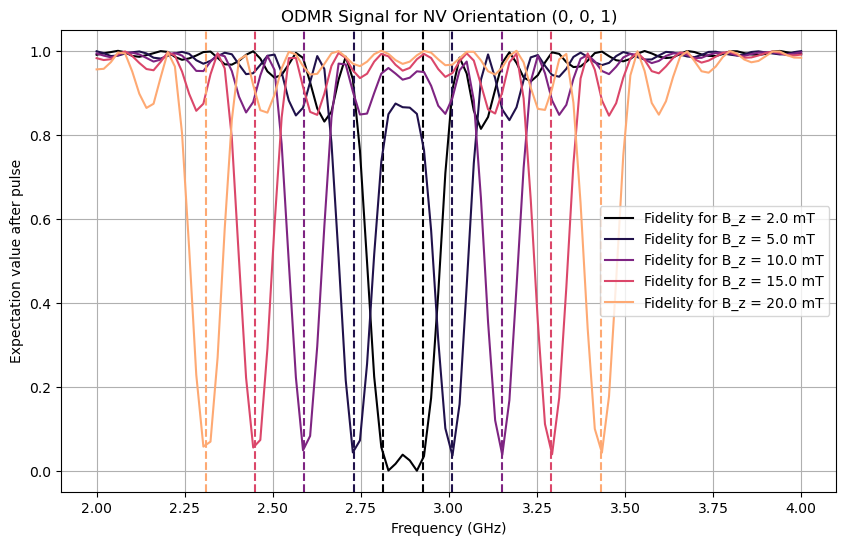

In [16]:
import os
import hashlib
import csv

B_values = [0.005, 0.01, 0.015, 0.02]

# create unique filename given set of parameters (for caching)
def parameter_hash(params):
    params_str = "_".join(map(str, params))
    return hashlib.sha256(params_str.encode()).hexdigest()

def load_odmr_from_csv(file_path):
    expectations = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            if row and row[0] == 'Frequencies':
                break  # Skip preamble
        for row in reader:
            if row:
                expectations.append(float(row[1]))
    return expectations

def save_odmr_to_csv(file_path, params, expectations):
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write the parameters in the preamble
        for key, value in params.items():
            writer.writerow([key, value])
        # Write a blank row for separation
        writer.writerow([])
        # Write the expectation values
        writer.writerow(['Frequencies', 'Expectations'])
        for frequency, expectation in zip(params['frequencies'], expectations):
            writer.writerow([frequency, expectation])

def compute_eigenvalues(orientation, B_field):
    eigenvalues = effective_hamiltonian(orientation, B_field).eigenenergies()

    return eigenvalues

def expectation_after_evolution(time, initial_state, H0, evolution_steps, evolution_operator, frequency, amplitude):
    # Compute expectation value
    density_matrix = initial_state * initial_state.dag()
    H0 /= _2PI
    H = [H0, [evolution_operator, pulse]]
    times = np.linspace(0, time, evolution_steps)
    result = qt.mesolve(H, initial_state, times, args={"w": frequency, 'amp': amplitude})
    expectation_value = qt.expect(density_matrix, result.states[-1])

    return expectation_value

def odmr(B_field, orientation, frequencies, time, evolution_steps, initial_state, evolution_operator, amplitude):
    cache_dir = 'cache_odmr_folder'
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # Generate a hash for the parameters
    params = (B_field, orientation, tuple(frequencies), time, evolution_steps, initial_state, evolution_operator, amplitude)
    hash_str = parameter_hash(params)
    cache_file = os.path.join(cache_dir, f'{hash_str}.csv')

    # Check if the cache file exists, and if so return from there
    if os.path.exists(cache_file):
        return load_odmr_from_csv(cache_file)
    
    H0 = effective_hamiltonian(orientation, B_field)

    # Calculate expectation values
    expectations = []
    for frequency in frequencies:
        expectations.append(expectation_after_evolution(time, initial_state, H0, evolution_steps, evolution_operator, frequency, amplitude))

    # Save the fidelities to a cache file
    params_dict = {
        'B_field': B_field,
        'orientation': orientation,
        'frequencies': frequencies,
        't': time,
        'n_evolution': evolution_steps,
        'amp': amplitude
    }
    save_odmr_to_csv(cache_file, params_dict, expectations)

    return expectations


frequencies = np.linspace(2, 4, 100)

time = 50
evolution_steps = 100

orientation = (0, 0, 1)

# Hard-coded values for B_z (in Tesla)
B_z_values = np.array([2 / 1000, 5 / 1000, 10 / 1000, 15 / 1000, 20 / 1000])

# Normalize B_z_values for color mapping
norm = plt.Normalize(B_z_values.min(), B_z_values.max()*1.2)
colors = cm.magma(norm(B_z_values))

plt.figure(figsize=(10, 6))

for B_z, color in zip(B_z_values, colors):
    # Magnetic field in Cartesian coordinates
    B_field = [0, 
               0, 
               B_z]
    
    # Calculate the ODMR signal for given orientation
    fidelity = odmr(B_field, orientation, frequencies, time, evolution_steps, state_zero, Sx, 0.1)

    # Compute the eigenvalues and resonant frequencies for the given orientation
    e0, em1, ep1 = compute_eigenvalues(orientation, B_field) / _2PI
    resonant_frequencies = (em1 - e0, ep1 - e0)
    print(f'B_z = {B_z*1000:.1f} mT: Resonant values {em1 - e0:.4f} and {ep1 - e0:.4f} GHz')

    # Plot fidelity with resonant frequencies as dashed lines
    plt.plot(frequencies, fidelity, label=f'Fidelity for B_z = {B_z*1000:.1f} mT', color=color)
    plt.axvline(resonant_frequencies[0], color=color, linestyle='--')
    plt.axvline(resonant_frequencies[1], color=color, linestyle='--')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Expectation value after pulse')
plt.title('ODMR Signal for NV Orientation (0, 0, 1)')
plt.legend()
plt.grid(True)

plt.show()



# Angle dependence of ODMR spectrum

Now the magnitude of B is arbitrarily chosen to be $20$ mT, and the angle between the NV orientation and the applied magnetic field is varied.

Azimuthal angle = 0°: Resonant values 2.3094 and 3.4306 GHz
Azimuthal angle = 30°: Resonant values 2.4285 and 3.3952 GHz
Azimuthal angle = 45°: Resonant values 2.5585 and 3.3457 GHz
Azimuthal angle = 60°: Resonant values 2.7115 and 3.2703 GHz
Azimuthal angle = 75°: Resonant values 2.8675 and 3.1695 GHz
Azimuthal angle = 90°: Resonant values 2.9756 and 3.0812 GHz


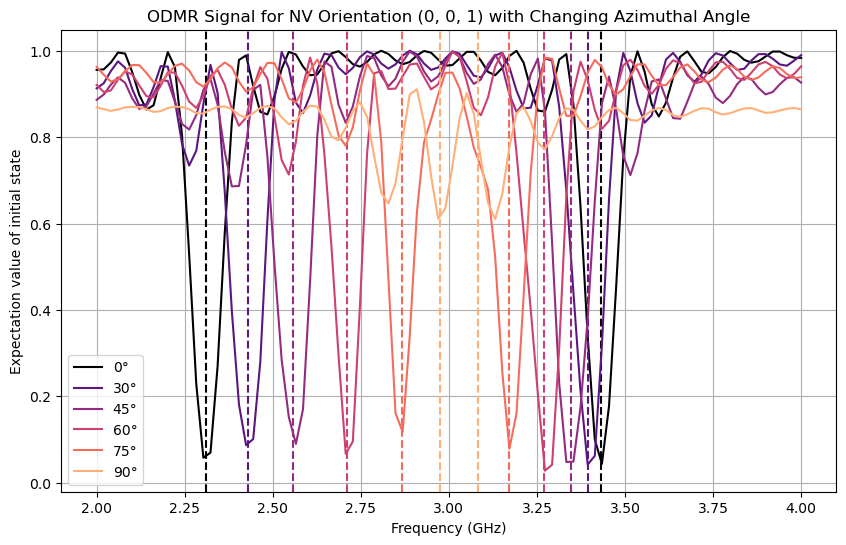

In [17]:
angles = np.array([0, 30, 45, 60, 75, 90])  # degrees
B_magnitude = 20 / 1000

# Normalize colors to reflect angles
norm = plt.Normalize(angles.min(), angles.max()*1.2)
colors = cm.magma(norm(angles))

# Plot the results for each azimuthal angle
plt.figure(figsize=(10, 6))

for angle, color in zip(angles, colors):
    angle_rad = np.deg2rad(angle)
    
    B_field = [
        0 / 1000,  # B_x = 0
        B_magnitude * np.sin(angle_rad),
        B_magnitude * np.cos(angle_rad)
    ]
    
    # Calculate the ODMR signal for the given orientation
    fidelity = odmr(B_field, orientation, frequencies, time, evolution_steps, state_zero, Sx, 0.1)

    e0, em1, ep1 = compute_eigenvalues(orientation, B_field) / _2PI
    resonant_frequencies = (em1 - e0, ep1 - e0)
    print(f'Azimuthal angle = {angle}°: Resonant values {em1 - e0:.4f} and {ep1 - e0:.4f} GHz')

    # Plot fidelity with resonant frequencies as dashed lines
    plt.plot(frequencies, fidelity, label=f'{angle}°', color=color)
    plt.axvline(resonant_frequencies[0], color=color, linestyle='--')
    plt.axvline(resonant_frequencies[1], color=color, linestyle='--')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Expectation value of initial state')
plt.title('ODMR Signal for NV Orientation (0, 0, 1) with Changing Azimuthal Angle')
plt.legend()
plt.grid(True)

plt.show()

Observe that the gaps are no longer centered around zero field splitting $D$, furthermore the spliting of resonant frequencies reduces for increasing angle.